In [39]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError #PIL is python image library
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
# Function to load images from a directory and label them
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])  # Filter to only directories
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                # Open the image file and convert to RGB
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Ensure all images are RGB
                    img = img.resize((100, 100))
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
            except (IOError, UnidentifiedImageError) as e:
                # Skip files that can't be identified as images
                print(f"Skipping file {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load training and testing data
train_folder = 'multiclassCNN/train'
test_folder = 'multiclassCNN/test'

x_train, y_train = load_images_from_folder(train_folder)
x_test, y_test = load_images_from_folder(test_folder)

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [22]:

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [23]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') 
])


In [24]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [25]:

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [29]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])


Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 49s 200ms/step - accuracy: 0.4924 - loss: 1.6167 - val_accuracy: 0.5149 - val_loss: 1.5930 - learning_rate: 0.0010
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 51s 220ms/step - accuracy: 0.5087 - loss: 1.5578 - val_accuracy: 0.5111 - val_loss: 1.6310 - learning_rate: 0.0010
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 48s 206ms/step - accuracy: 0.5091 - loss: 1.5587 - val_accuracy: 0.5204 - val_loss: 1.5804 - learning_rate: 0.0010
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 47s 203ms/step - accuracy: 0.5163 - loss: 1.5481 - val_accuracy: 0.5285 - val_loss: 1.6027 - learning_rate: 0.0010
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - accuracy: 0.5231 - loss: 1.5300 - val_accuracy: 0.5367 - val_loss: 1.5245 - learning_rate: 0.0010
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - accuracy: 0.5165 - loss: 1.5415 - val_accuracy: 0.5253 - val_loss: 1.5616 - learning_rate: 0.0010
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - accuracy: 0.5

In [61]:

# Evaluate the model
model.evaluate(x_test, y_test)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6551 - loss: 1.2418


[1.3076902627944946, 0.627919614315033]

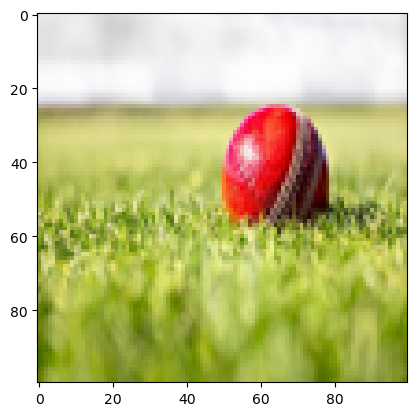

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class: cricket_ball, Actual Class: cricket_ball


In [62]:
# Display a random image and its prediction
idx2 = random.randint(0, len(x_test) - 1)
plt.imshow(x_test[idx2])
plt.show()

# Predict the class of the image
y_pred = model.predict(x_test[idx2, :].reshape(1, 100, 100, 3))
predicted_class_idx = np.argmax(y_pred)

# Get the class names from the folder structure
class_names = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))])

# Map the predicted class index and actual class index to their respective class names
predicted_class_name = class_names[predicted_class_idx]
actual_class_name = class_names[np.argmax(y_test[idx2])]

print(f"Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")
